In [1]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np 

In [2]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

train_set = MNIST(
    './', 
    download=True,
    transform=transforms.ToTensor(), 
    train=True
)

test_set = MNIST(
    './', 
    download=True,
    transform=transforms.ToTensor(), 
    train=False
)

--2021-10-02 13:19:24--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-10-02 13:19:24--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [     <=>            ]  33.20M  35.4MB/s    in 0.9s    

2021-10-02 13:19:25 (35.4 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tra

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=128, shuffle=False)

In [19]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
        nn.Conv2d(1, 48, kernel_size=3, stride=1, padding=1), nn.ReLU(),
        nn.Conv2d(48, 48, kernel_size=3, stride=1, padding=1), nn.ReLU(),
        nn.Conv2d(48, 48, kernel_size=3, stride=1, padding=1), nn.ReLU(),
        nn.Conv2d(48, 48, kernel_size=3, stride=1, padding=1), nn.ReLU(),
        nn.Conv2d(48, 48, kernel_size=3, stride=1, padding=1), nn.ReLU(),
        nn.Conv2d(48, 48, kernel_size=3, stride=1, padding=1), nn.ReLU(),
        nn.Conv2d(48, 1, kernel_size=1), nn.Tanh()
        
    )
  def forward(self, x):
    perturbation = self.net(x)
    return perturbation

In [55]:
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
        nn.Conv2d(1, 48, kernel_size=3), nn.ReLU(),
        nn.Conv2d(48, 48, kernel_size=3, stride=2, padding=1), nn.ReLU(),
        nn.Conv2d(48, 96, kernel_size=3), nn.ReLU(),
        nn.Conv2d(96, 96, kernel_size=3, stride=2, padding=1), nn.ReLU(),
        nn.Conv2d(96, 96, kernel_size=3, stride=1, padding=1), nn.ReLU(),
        nn.Conv2d(96, 96, kernel_size=1, stride=1, padding=1), nn.ReLU(),
        nn.Conv2d(96, 10, kernel_size=1), 
        nn.AvgPool2d(kernel_size=8),
    )
  def forward(self, x):
    logits = F.softmax(self.net(x), dim=1)
    return logits.view(-1, 10)

In [79]:
# HYPERPARAMETERS
epochs = 10
epsilon = 0.1
alpha = 0.5
cg = 0.5
k = 1
generator = Generator().cuda()
classifier = Classifier().cuda()
# Standard (non-adversarial) training loop
def train(device, train_loader):
  generator_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-6)
  classifier_optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)
  loss = nn.CrossEntropyLoss()
  for epoch in range(epochs):
    for i, (x,y) in enumerate(train_loader):
      x, y = x.to(device), y.to(device)

      generator_optimizer.zero_grad()
      perturbation = generator(x)
      probs = F.softmax(classifier(x + perturbation), dim=1)
      batch_loss = probs + cg * torch.norm(perturbation, p=2)
      gen_loss = batch_loss.mean()
      gen_loss.backward()
      generator_optimizer.step()

      """try:
        x, y = next(train_loader_iter)
      except StopIteration:
        train_loader_iter = iter(train_loader)
        x, y = next(train_loader_iter)
      x,y = x.to(device), y.to(device)"""
      classifier_optimizer.zero_grad()
      perturbation = generator(x)
      classifier_loss = alpha * loss(classifier(x), y) + (1-alpha) * loss(classifier(x+perturbation), y)
      classifier_loss.backward()
      classifier_optimizer.step()      
      if (i%100 == 0):
        print('Epoch [{}/{}], Step [{}/{}], Generator_loss: {}, Classifier_loss: {}'.format(epoch+1, epochs, i+1, len(train_loader), gen_loss, classifier_loss))


In [80]:
train(device, train_loader) 

Epoch [1/10], Step [1/469], Generator_loss: 3.378041982650757, Classifier_loss: 2.3027095794677734
Epoch [1/10], Step [101/469], Generator_loss: 2.8898940086364746, Classifier_loss: 1.9934202432632446
Epoch [1/10], Step [201/469], Generator_loss: 2.3850109577178955, Classifier_loss: 1.7614988088607788
Epoch [1/10], Step [301/469], Generator_loss: 1.8578941822052002, Classifier_loss: 1.7886707782745361
Epoch [1/10], Step [401/469], Generator_loss: 1.3481062650680542, Classifier_loss: 1.7943413257598877
Epoch [2/10], Step [1/469], Generator_loss: 1.0729235410690308, Classifier_loss: 1.7833044528961182
Epoch [2/10], Step [101/469], Generator_loss: 0.88849276304245, Classifier_loss: 1.727144718170166
Epoch [2/10], Step [201/469], Generator_loss: 0.8230485916137695, Classifier_loss: 1.64340078830719
Epoch [2/10], Step [301/469], Generator_loss: 0.7799439430236816, Classifier_loss: 1.67246413230896
Epoch [2/10], Step [401/469], Generator_loss: 0.7412733435630798, Classifier_loss: 1.678795814

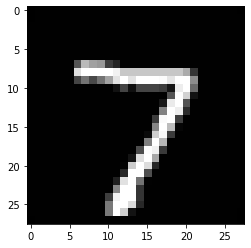

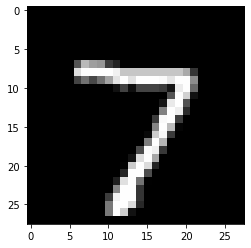

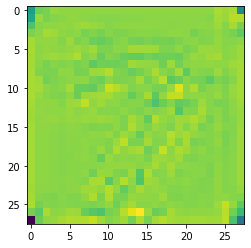

0.006046038


In [103]:
for x,y in test_loader:
  x,y = x.to(device), y.to(device)
  perturbation = generator(x)
  image = (x + perturbation).detach().cpu().numpy()
  original = x[0][0].cpu().numpy()
  plt.imshow(image[0][0], cmap='gray')
  plt.show()
  plt.imshow(original, cmap='gray')
  plt.show()
  plt.imshow((image-original)[0][0])
  plt.show()
  print(np.linalg.norm((image-original)[0][0], ord=2))
  break

In [86]:
import matplotlib.pyplot as plt